## There are two crucial stages for this bit. 

#### Firstly we need to be able to get the letters from the identity into their own boxes. Here you see an example, but its not so robust right now. 
#### Then we take 2 models trained, one trained on the relevant letters and one trained on the numbers (there are good publically available datasets) and predict. 

In [4]:
from google.cloud import vision
from google.cloud import storage
from PIL import Image
import numpy as np
import os, sys
from image import *
import csv  
from io import BytesIO
from IPython import display

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = r"../guppies-test-4c48569421d8.json"

import torch
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

from skimage.transform import rotate
from skimage.draw import polygon

import scipy
import h5py

from tensorflow.keras.layers import StringLookup

from ML_helper import *

from corrections import *
from image import * 
from handling import *

In [5]:
def extract_vertices(bounding_box):
    vertices = []
    for vertex in bounding_box.vertices:
        vertices.append((vertex.x, vertex.y))
    return vertices

def combine_paraboxes(para_boxes):
    X_points = []
    Y_points = []
    for box in para_boxes:
        for vertex in box:
            X_points.append(vertex[0])
            Y_points.append(vertex[1])

    X_points = np.array(X_points)
    Y_points = np.array(Y_points)

    para_box = np.zeros((4,2), dtype=np.int32)

    para_box[0] = [X_points.min(), Y_points.min()]
    para_box[1] = [X_points.max(), Y_points.min()]
    para_box[2] = [X_points.max(), Y_points.max()]
    para_box[3] = [X_points.min(), Y_points.max()]

    return para_box

def rotate_image_and_transform_coordinates(image, coordinates, angle):

    angle = np.rad2deg(angle)

    # Calculate the transformation matrix.
    transform_matrix = cv2.getRotationMatrix2D((image.shape[1] // 2, image.shape[0] // 2), angle, 1)

    # Apply the transformation matrix to the coordinates.
    image = cv2.warpAffine(image, transform_matrix, (image.shape[1], image.shape[0]))

    transformed_coordinates = [(transform_matrix[:,:2] @ coordinates[i].T).T + transform_matrix[:,2] for i in range(len(coordinates))]

    return image, transformed_coordinates

def zero_printed_text(image, threshold=40, verbose=False):

    mask = np.zeros(image.shape, dtype=np.uint8)

    mask[(image>0) & (image<threshold)] = 1

    nx, ny = image.shape

    # mask[nx//6:4*nx//6, ny//6:5*ny//6] = 0 #havent worked this bit out yet

    dilated = cv2.dilate(mask, np.ones((9,9), np.uint8), iterations=1)

    return image * (1-dilated)


In [6]:
def GetImageAndParaBox(file, client, verbose=False):
    client = vision.ImageAnnotatorClient()
    whole_image = RetreiveImage(file, verbose=False)

    img_byte_array = CroppedImage(whole_image, verbose=False)

    decoded = np.frombuffer(img_byte_array.getvalue(), dtype=np.uint8)
    frame = cv2.imdecode(decoded, cv2.IMREAD_COLOR) 

    content = img_byte_array.getvalue()
    image = vision.Image(content=content)

    response = client.document_text_detection(image=image, image_context={"language_hints": ["en"]})

    character = []
    character_params = []

    for a, page in enumerate(response.full_text_annotation.pages):
        for b, block in enumerate(page.blocks):

            for c, paragraph in enumerate(block.paragraphs):
                
                for d, word in enumerate(paragraph.words):
                    for e, symbol in enumerate(word.symbols):

                        character.append(symbol.text)

                        character_params.append([a, b, c, d, e])


                        if verbose: print(character[-1], 'pageno:'+str(a), 'blockno:'+str(b), 'paragraphno:'+str(c), 'wordno:'+str(d), 'symbolno:'+str(e))


    character_params = np.array(character_params)

    # If we have not read enough characters, the label may be moved outside the cropping box. Resort to reading the whole image and reducing.
    if len(character) < 7:
        if verbose: print('running with whole image')

        client = vision.ImageAnnotatorClient()
        content = whole_image.getvalue()
        image = vision.Image(content=content)
        response = client.document_text_detection(image=image, image_context={"language_hints": ["en"]})

        decoded = np.frombuffer(whole_image.getvalue(), dtype=np.uint8)
        frame = cv2.imdecode(decoded, cv2.IMREAD_COLOR) 

        # content = img_byte_array.getvalue()
        # image = vision.Image(content=content)

        # response = client.document_text_detection(image=image, image_context={"language_hints": ["en"]})

        character = []
        character_params = []

        for a, page in enumerate(response.full_text_annotation.pages):
            for b, block in enumerate(page.blocks):

                for c, paragraph in enumerate(block.paragraphs):
                    
                    for d, word in enumerate(paragraph.words):
                        for e, symbol in enumerate(word.symbols):

                            character.append(symbol.text)

                            character_params.append([a, b, c, d, e])


                            if verbose: print(character[-1], 'pageno:'+str(a), 'blockno:'+str(b), 'paragraphno:'+str(c), 'wordno:'+str(d), 'symbolno:'+str(e))


        character_params = np.array(character_params)

    lead_character = character[0]
    while lead_character != 'F' and lead_character != 'M':
        if verbose: print('removing character', character[0])
        character = character[1:]
        character_params = character_params[1:]
        if verbose: print('Reduced characters are now:', character)
        if len(character) < 7:
            if verbose: print("Not enough characters to continue. Exiting with exit code '1', '1'")
            return '1', '1'
        lead_character = character[0]
        if verbose: print('Lead character is now:', lead_character)


    if verbose: print('character in position 5:', character[5])

    # F/M height
    page_no, block_no, paragraph_no, word_no, symbol_no = character_params[0] #take the 5th character and use the words boudning box.
    first_bounds = extract_vertices(page.blocks[block_no].paragraphs[paragraph_no].words[word_no].symbols[symbol_no].bounding_box)
    first_height = np.sort(first_bounds[0])[0]

    # 5th character bounding box is:
    page_no, block_no, paragraph_no, word_no, symbol_no = character_params[5] #take the 5th character and use the words boudning box.
    character_bounds = extract_vertices(page.blocks[block_no].paragraphs[paragraph_no].words[word_no].symbols[symbol_no].bounding_box)
    character_height = np.sort(character_bounds[0])[0]
    if verbose: print('character height is:', character_height)

    # Vertices for remaining letters
    ID_vertices = []
    ID_vertices.append(np.array(character_bounds))

    for block in page.blocks:
        for paragraph in block.paragraphs:
            for word in paragraph.words:
                for symbol in word.symbols:
                    vertices = extract_vertices(symbol.bounding_box)
                    
                    if verbose: print('character:', symbol.text, 'height:', np.sort(vertices[0])[0], 'other height:', np.sort(vertices[0])[1])

                    if (character_height - ( (character_height - first_height) * 0.2)) <= np.sort(vertices[0])[0] <= (character_height + ( (character_height - first_height) * 0.2)):
                        ID_vertices.append(np.array(vertices))

                        if verbose: print('character:', symbol.text, 'is within bounds')

    for i, vertex in enumerate(ID_vertices):
        for j, coord in enumerate(vertex):
            ID_vertices[i][j] = np.sort(coord)[::-1]

    para_boxes = np.array(ID_vertices)
    para_box = combine_paraboxes(para_boxes)

    plt.imshow(frame)

    return frame, para_box

In [7]:
def extract_ID_handwriting(frame, paragraph_vertices, verbose=False):
        
    padx = 60
    pady = 40

    #firstly find the box around the identity, and also calculate the approx angle of rotation of that box. 
    adapted_para_box = paragraph_vertices.copy()

    x = np.argsort(paragraph_vertices[:,0])
    y = np.argsort(paragraph_vertices[:,1])


    adapted_para_box[x[:2],0] = np.max( np.stack(( paragraph_vertices[x[:2],0] - padx , [0,0] )), axis=0)

    adapted_para_box[x[2:],0] = np.min( np.stack(( paragraph_vertices[x[2:],0] + 1.2*padx , [frame.shape[1],frame.shape[1]] )), axis=0)

    adapted_para_box[y[:2],1] = np.max( np.stack(( paragraph_vertices[y[:2],1] - pady, [0,0] )), axis=0) 
    adapted_para_box[y[2:],1] = np.min( np.stack(( paragraph_vertices[y[2:],1] + pady , [frame.shape[0],frame.shape[0]])), axis=0)


    rel_area = polygon(adapted_para_box[:,1], adapted_para_box[:,0]) 
    mask1 = np.zeros(frame.shape[:2], dtype=np.uint8)
    mask1[rel_area] = 1

    miny, maxy, minx, maxx = np.min(adapted_para_box[:,0]), np.max(adapted_para_box[:,0]), np.min(adapted_para_box[:,1]), np.max(adapted_para_box[:,1])


    idx = paragraph_vertices[:,1].argsort()[:2]
    dx = paragraph_vertices[idx[1],0] - paragraph_vertices[idx[0],0]
    dy = paragraph_vertices[idx[1],1] - paragraph_vertices[idx[0],1]

    angle = np.arctan2(dy,dx)


    if verbose:
        fig,ax = plt.subplots(1,5,dpi=250)
        ax[0].imshow(frame)
    frame = frame*mask1[...,None] #mask the image

    if verbose: ax[1].imshow(frame)

    frame = np.mean(frame, axis=2)
    frame = frame[minx:maxx, miny:maxy]

    if verbose: ax[2].imshow(frame)

    frame = rotate(frame, -angle, resize=False, ) #rotate the image
    # frame = (1-frame) #invert and threshold.
    # frame[frame < 0.5] = 0
    # frame[frame !=0] = 1

    if verbose: ax[3].imshow(frame)


    frame = zero_printed_text(frame, threshold = 30) #threshold needs to be found algorithmically.


    hist = np.histogram(frame, bins=100)
    peaks,_ = scipy.signal.find_peaks(hist[0], height=1000, distance=7)

    if len(peaks) == 2:
        peak_handwriting = peaks[0]
        peak_background = peaks[1]

        thresh = 1*hist[1][peak_background]/4  + 3*hist[1][peak_handwriting]/4
    else:
        thresh = frame.max()*0.85
        


    frame[frame>thresh] = 0 
    frame[frame!=0] = 1

    if verbose: ax[4].imshow(frame)


    return frame


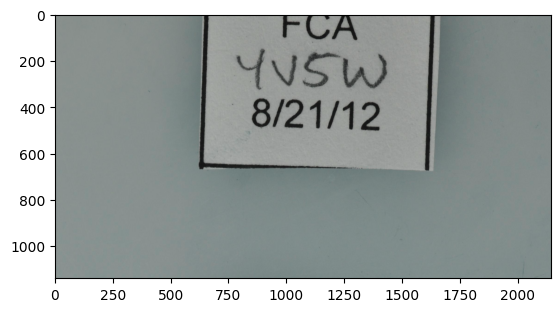

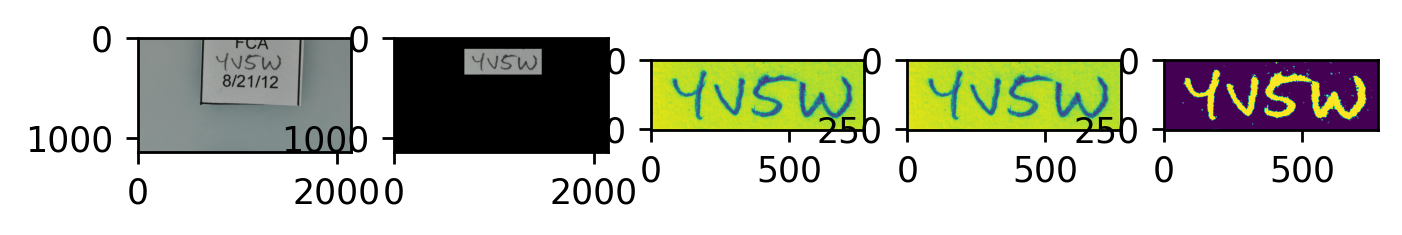

In [55]:
file = 'Manually_Labelled/New/CA1208/FCA4V5W1208.JPG'
client = vision.ImageAnnotatorClient()
frame, para_box = GetImageAndParaBox(file, client)

%matplotlib inline
ID = extract_ID_handwriting(frame, para_box, verbose=True)

In [56]:
folders = ['Manually_Labelled/New/CA1208', 'Manually_Labelled/New/CA1207' ,'Manually_Labelled/New/CA1206','Manually_Labelled/New/CA1209jpegs JB']

bucket_name = "guppy_images"
storage_client = storage.Client()
bucket = storage_client.bucket(bucket_name)

file_list = []
for folder in folders:
    s_file_list = storage_client.list_blobs(bucket_name,prefix=folder)
    s_file_list = [file.name for file in s_file_list]
    file_list.extend(s_file_list)

In [57]:
def extract_ID(file_list):
    
    id_list = []
    for f in file_list:
        f = f.split('/')[-1].split('.')[0]

        title = f[:3]
        date = f[-4:]
        id = f[3:-4]
        id_list.append(id)

    return id_list

In [58]:
IDs = np.array(extract_ID(file_list))

F pageno:0 blockno:0 paragraphno:0 wordno:0 symbolno:0
C pageno:0 blockno:0 paragraphno:0 wordno:0 symbolno:1
A pageno:0 blockno:0 paragraphno:0 wordno:0 symbolno:2
3 pageno:0 blockno:0 paragraphno:0 wordno:1 symbolno:0
√ pageno:0 blockno:0 paragraphno:0 wordno:1 symbolno:1
7 pageno:0 blockno:0 paragraphno:0 wordno:1 symbolno:2
4 pageno:0 blockno:0 paragraphno:0 wordno:1 symbolno:3
8 pageno:0 blockno:0 paragraphno:1 wordno:0 symbolno:0
/ pageno:0 blockno:0 paragraphno:1 wordno:0 symbolno:1
2 pageno:0 blockno:0 paragraphno:1 wordno:0 symbolno:2
1 pageno:0 blockno:0 paragraphno:1 wordno:0 symbolno:3
/ pageno:0 blockno:0 paragraphno:1 wordno:0 symbolno:4
1 pageno:0 blockno:0 paragraphno:1 wordno:0 symbolno:5
2 pageno:0 blockno:0 paragraphno:1 wordno:0 symbolno:6
character in position 5: 7
character height is: 152
character: F height: 15 other height: 1017
character: C height: 17 other height: 1121
character: A height: 20 other height: 1231
character: 3 height: 155 other height: 888
charac

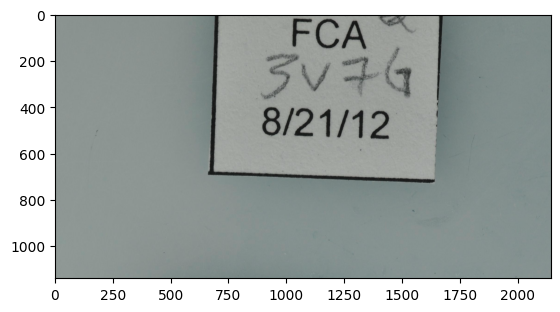

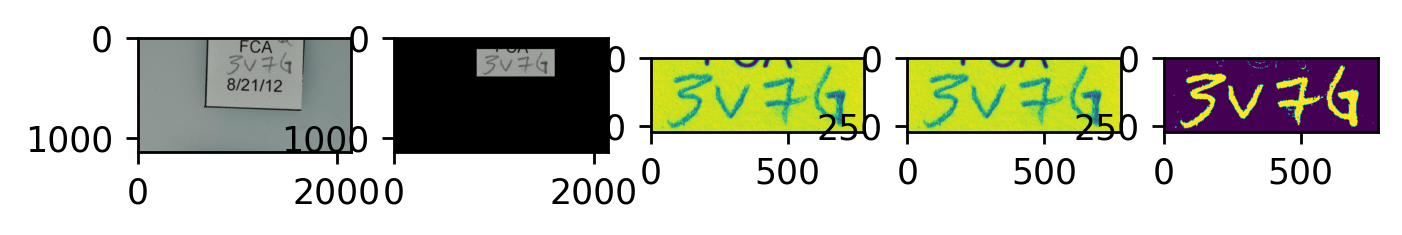

In [59]:
frame, para_box = GetImageAndParaBox(file_list[78], client = client, verbose=True)

im_ID = extract_ID_handwriting(frame, para_box, verbose=True)
label_ID = IDs[78]

In [60]:
image_width, image_height = 256, 64

In [61]:
characters = []
for i in IDs:
    for j in i:
        if j not in characters:
            characters.append(j)

AUTOTUNE = tf.data.AUTOTUNE

# Mapping characters to integers.
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters.
num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

max_len = len(max(IDs, key=len))

In [62]:
model = tf.keras.Sequential()
model.add(char_to_num)
model.add(num_to_char)
model.build(input_shape=(1,1))
model.save('stringlookups.h5') #need to save these lookup tables for use in model.

/Users/jordan/anaconda3/envs/Guppies/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [63]:
model = tf.keras.models.load_model('stringlookups.h5');

char_to_num = model.layers[0]
num_to_char = model.layers[1]

In [64]:
vectorize_label(label_ID, char_to_num, max_len=max_len, padding_token=99).numpy()[None]

array([[14,  9, 11,  8,  1, 99, 99, 99]])

In [65]:
# # h5f.close()
# h5f = h5py.File(('dataset.h5'), 'w')

# image_width, image_height = 256, 64
   
# first_image = preprocess_image(im_ID[...,None],(image_width,image_height)).numpy()[None,...,0]
# first_label = vectorize_label(label_ID, char_to_num, max_len=max_len, padding_token=99).numpy()[None]

# h5f.create_dataset('images', data=first_image, compression="gzip", chunks=True, maxshape=(None,image_height,image_width))
# h5f.create_dataset('labels', data=first_label, compression="gzip", chunks=True, maxshape=(None,max_len))


In [66]:
# some_im_IDs = []
# some_label_IDs = []

# idx = np.arange(0, len(file_list))
# np.random.shuffle(idx)


# for i in range(len(file_list)):
#     st = str(i)
#     try: 
#         frame, para_box = GetImageAndParaBox(file_list[idx[i]], client = client, verbose=False)
#         im_ID = extract_ID_handwriting(frame, para_box, verbose=False)


#         image = preprocess_image(im_ID[...,None],(image_width,image_height)).numpy()[None,...,0]
#         label = vectorize_label(IDs[idx[i]], char_to_num, max_len=max_len, padding_token=99).numpy()[None]

#         h5f['images'].resize((h5f['images'].shape[0] + 1),axis=0)
#         h5f['images'][-1:] = image

#         h5f['labels'].resize((h5f['labels'].shape[0] + 1),axis=0)
#         h5f['labels'][-1:] = label

#         # some_im_IDs.append(im_ID)
#         # some_label_IDs.append(IDs[idx[i]])
#         st += ' success'

#     except: st += ' fail'
#     print(st)

# h5f.close()
    

V pageno:0 blockno:0 paragraphno:0 wordno:0 symbolno:0
M pageno:0 blockno:1 paragraphno:0 wordno:0 symbolno:0
C pageno:0 blockno:1 paragraphno:0 wordno:0 symbolno:1
A pageno:0 blockno:1 paragraphno:0 wordno:0 symbolno:2
6 pageno:0 blockno:1 paragraphno:0 wordno:1 symbolno:0
7 pageno:0 blockno:1 paragraphno:0 wordno:1 symbolno:1
7 pageno:0 blockno:1 paragraphno:0 wordno:1 symbolno:2
V pageno:0 blockno:1 paragraphno:0 wordno:2 symbolno:0
8 pageno:0 blockno:1 paragraphno:0 wordno:3 symbolno:0
/ pageno:0 blockno:1 paragraphno:0 wordno:3 symbolno:1
2 pageno:0 blockno:1 paragraphno:0 wordno:3 symbolno:2
1 pageno:0 blockno:1 paragraphno:0 wordno:3 symbolno:3
/ pageno:0 blockno:1 paragraphno:0 wordno:3 symbolno:4
1 pageno:0 blockno:1 paragraphno:0 wordno:3 symbolno:5
2 pageno:0 blockno:1 paragraphno:0 wordno:3 symbolno:6
removing character V
Reduced characters are now: ['M', 'C', 'A', '6', '7', '7', 'V', '8', '/', '2', '1', '/', '1', '2']
Lead character is now: M
character in position 5: 7
cha

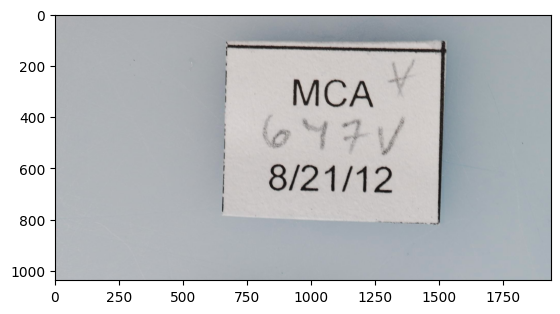

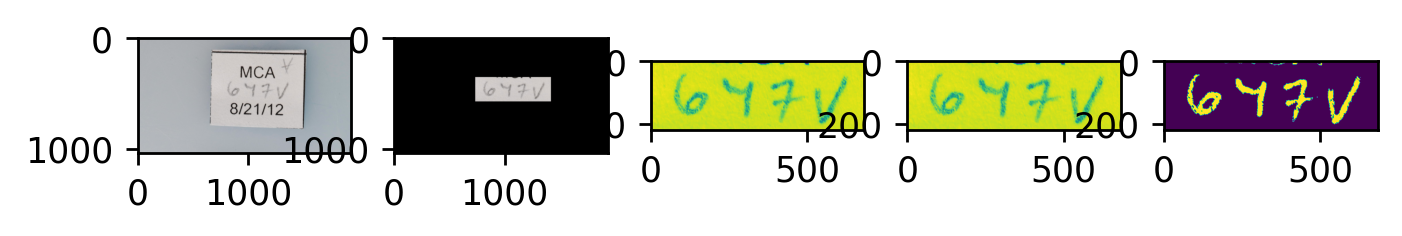

In [67]:
frame, para_box = GetImageAndParaBox(file_list[209], client = client, verbose=True)

im_ID = extract_ID_handwriting(frame, para_box, verbose=True)

In [2]:
new_files = ListAvaliableFiles("guppy_images", "Manually_Labelled/New")
new_jpg_files = [ x for x in new_files if "JPG" in x ]

np.random.shuffle(new_jpg_files)

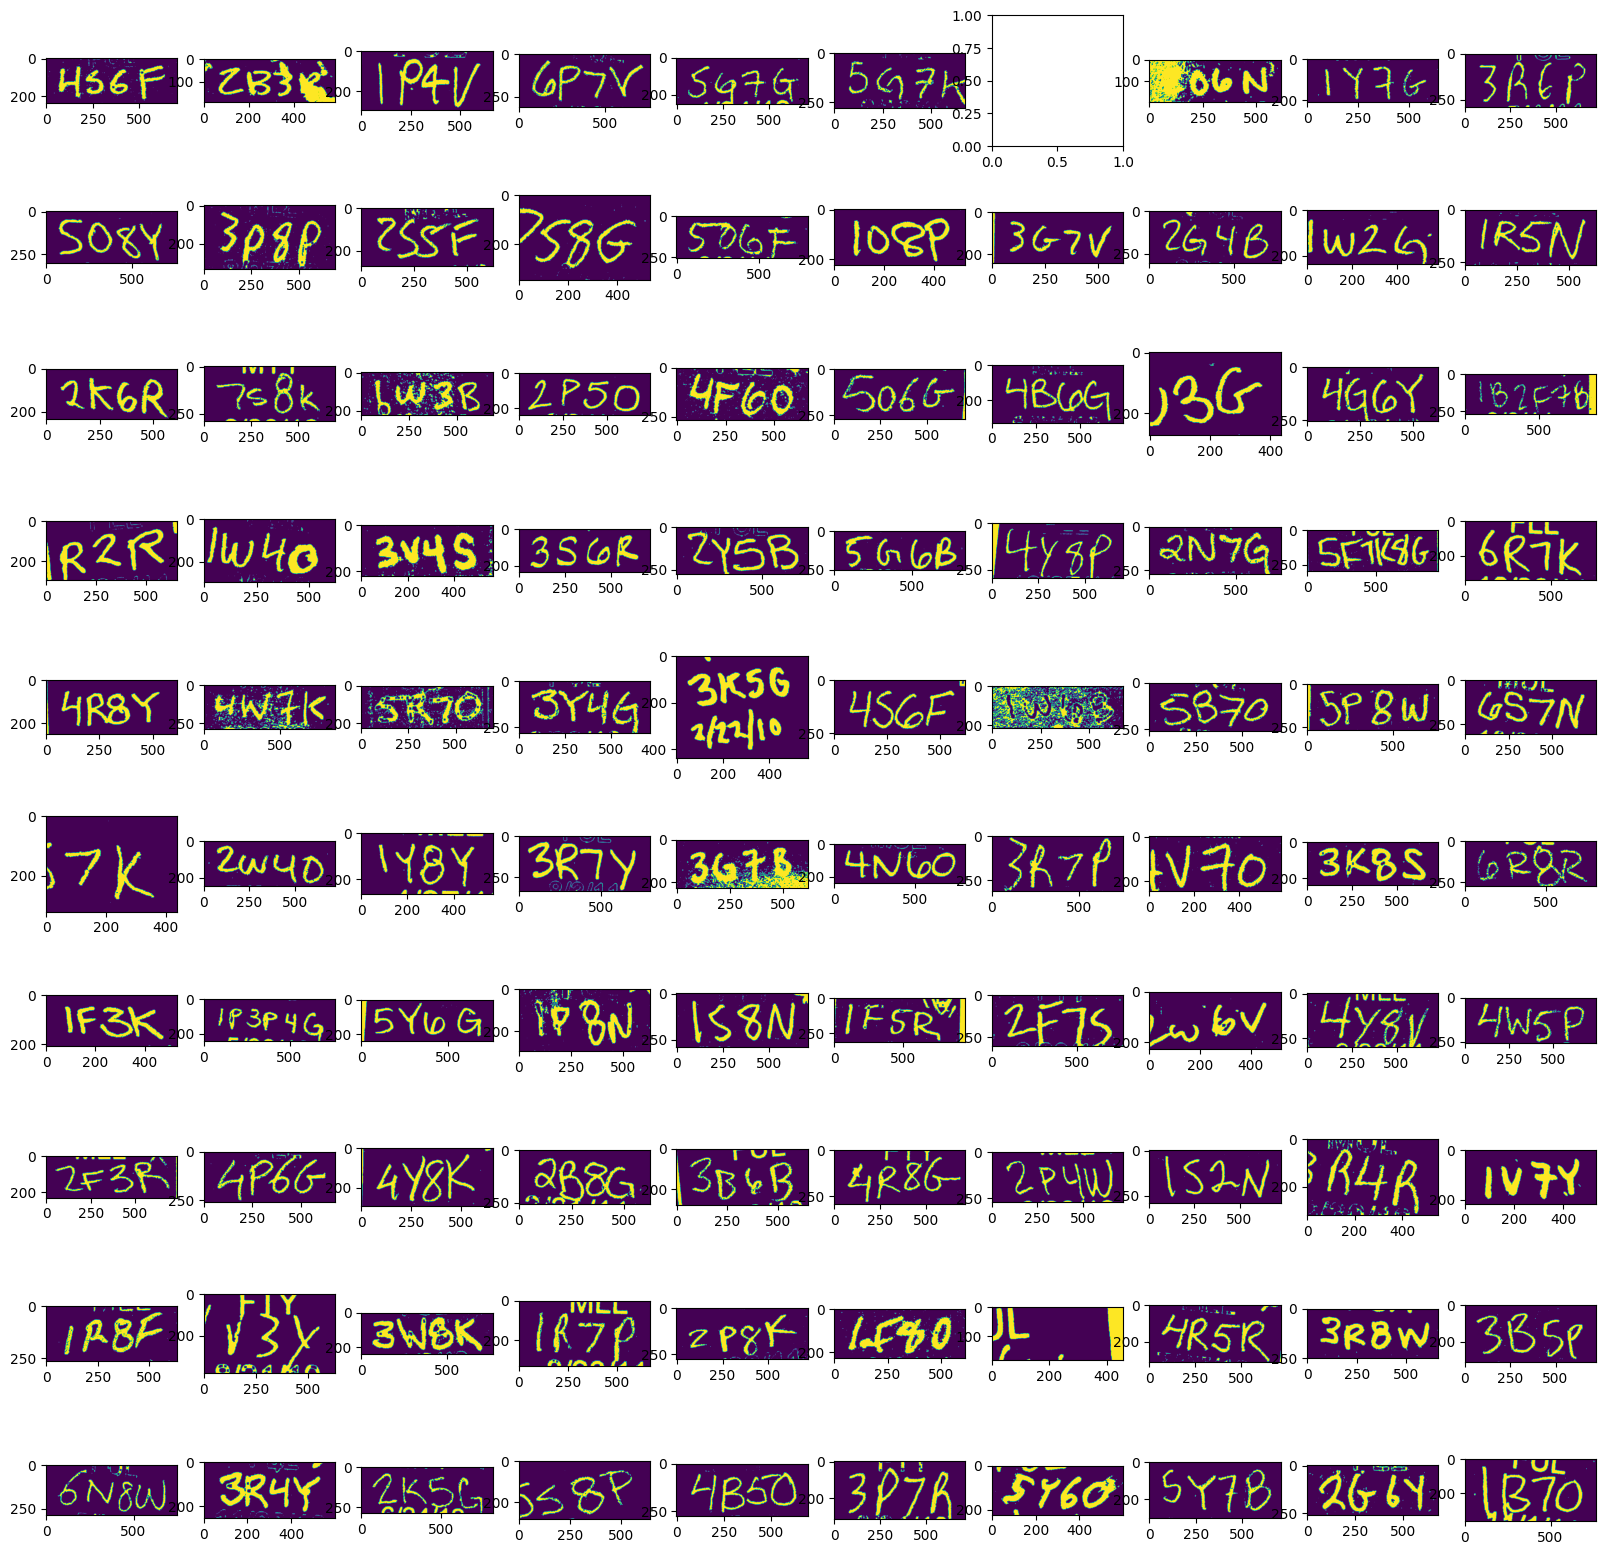

In [9]:
client = vision.ImageAnnotatorClient()

fig,ax = plt.subplots(10,10, figsize=(20,20))
for i in range(100):
    frame, para_box = GetImageAndParaBox(new_jpg_files[i], client, verbose=False)
    try:
        ID = extract_ID_handwriting(frame, para_box, verbose=False)
        ax[i//10, i%10].imshow(ID)
        # ax[i//10, i%10].set_title('Index: %i' %i)
    except:
        pass

# plt.tight_layout()

F pageno:0 blockno:0 paragraphno:0 wordno:0 symbolno:0
C pageno:0 blockno:0 paragraphno:0 wordno:0 symbolno:1
A pageno:0 blockno:0 paragraphno:0 wordno:0 symbolno:2
I pageno:0 blockno:0 paragraphno:0 wordno:1 symbolno:0
W pageno:0 blockno:0 paragraphno:0 wordno:1 symbolno:1
G pageno:0 blockno:0 paragraphno:0 wordno:1 symbolno:2
B pageno:0 blockno:0 paragraphno:0 wordno:1 symbolno:3
1 pageno:0 blockno:0 paragraphno:0 wordno:2 symbolno:0
1 pageno:0 blockno:0 paragraphno:0 wordno:2 symbolno:1
/ pageno:0 blockno:0 paragraphno:0 wordno:2 symbolno:2
2 pageno:0 blockno:0 paragraphno:0 wordno:2 symbolno:3
2 pageno:0 blockno:0 paragraphno:0 wordno:2 symbolno:4
/ pageno:0 blockno:0 paragraphno:0 wordno:2 symbolno:5
1 pageno:0 blockno:0 paragraphno:0 wordno:2 symbolno:6
2 pageno:0 blockno:0 paragraphno:0 wordno:2 symbolno:7
character in position 5: G
character height is: 323
character: F height: 163 other height: 942
character: C height: 165 other height: 1035
character: A height: 167 other heigh

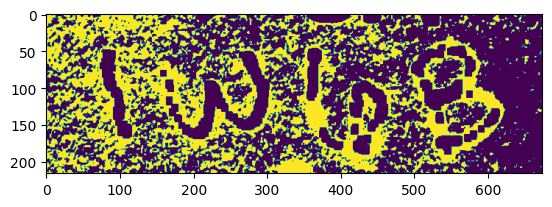

In [11]:
file = new_jpg_files[46]
frame, para_box = GetImageAndParaBox(file, client, verbose=True)
ID = extract_ID_handwriting(frame, para_box, verbose=False)
plt.imshow(ID)
print(file)

## Lets isolate single characters

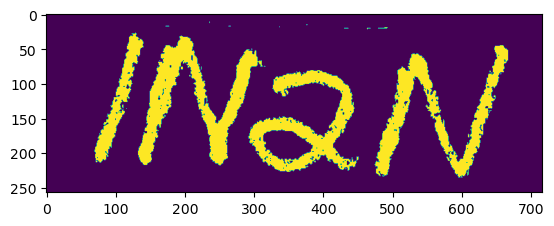

In [24]:
plt.imshow(ID)

In [79]:
num_components, labels, stats, centroids = cv2.connectedComponentsWithStats(np.uint8(ID))


In [80]:
rel_components = np.where(stats[:,-1] >800)[0][1:]

In [81]:
stats = stats[rel_components]

# stats = np.sort(stats, axis=0) #sort by their x coordinate to get in right order

In [89]:
characters[[0,1]]

TypeError: list indices must be integers or slices, not list

C:\Users\howards\AppData\Local\Temp\ipykernel_15848\1789865089.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  characters = np.array(characters)


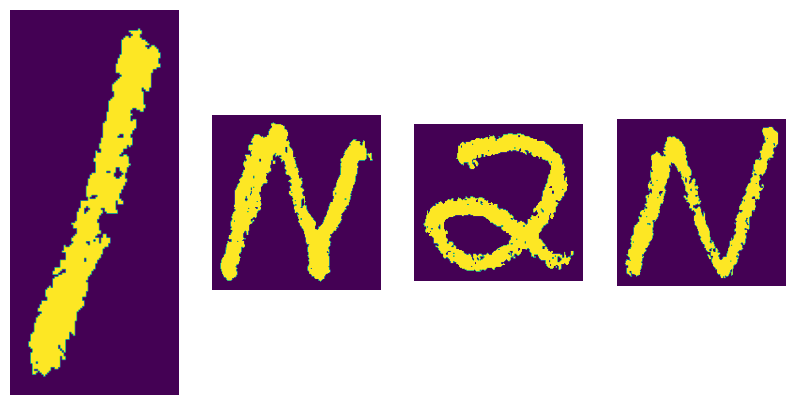

In [92]:
characters = []
pad = 10

for i in range(rel_components.shape[0]):

    y_start,x_start,width,height = stats[i,:4]

    char = labels[x_start-pad:x_start+height+pad,y_start-pad:y_start+width+pad] == rel_components[i]

    characters.append(char)

characters = np.array(characters)
characters = characters[np.argsort(stats[:,0])]
fig,ax = plt.subplots(1,rel_components.shape[0],figsize=(10,5))
for i in range(rel_components.shape[0]):
    ax[i].imshow(characters[i])
    ax[i].axis('off')

### now need to pad somewhat and get into 28$\times$28 format

In [154]:
samples = torch.zeros((len(characters), 1, 28, 28))

for i, char in enumerate(characters):


    #here we should really scale up if w and h are too small.
    h,w = char.shape
    pooler = torch.nn.AvgPool2d(10)

    
    eg = np.uint8(char)

    eg = cv2.dilate(eg, np.ones((5,5)), iterations = 1)

    if h>w:
        resize_h = 260
        resize_w = int(w * (resize_h/h))
        pad = (resize_h - resize_w)//2
        char = cv2.resize(np.uint8(char), (resize_w, resize_h)).astype(np.float32)

        char = torch.tensor(np.pad(char,((10,10),(pad,280-resize_w-pad)), mode = 'constant', constant_values = 0))
        
    else:
        resize_w = 260
        resize_h = int(h * (resize_w/w))
        pad = (resize_w - resize_h)//2
        char = cv2.resize(np.uint8(char), (resize_w, resize_h)).astype(np.float32)

        char = torch.tensor(np.pad(char,((pad,280-resize_h-pad),(10,10),), mode = 'constant', constant_values = 0))

    samples[i] = pooler(char.unsqueeze(0).unsqueeze(0))

samples = samples / torch.amax(samples, dim = (1,2,3), keepdim = True)

samples = samples* 255


In [155]:
cnn_let = torch.load('letter_model.pth')
cnn_num = torch.load('number_model.pth')

relevant_characters =  ['0','1','2','3','4','5','6','7','8','B','F','G','K','N','O','P','R','S','V','W','Y'] 

nums = relevant_characters[:9]
letters = relevant_characters[9:]

def preds_to_char(preds, chars):
    pred_idx = torch.max(preds, 1)[1].data.numpy().squeeze()
    return np.array([chars[i] for i in pred_idx])

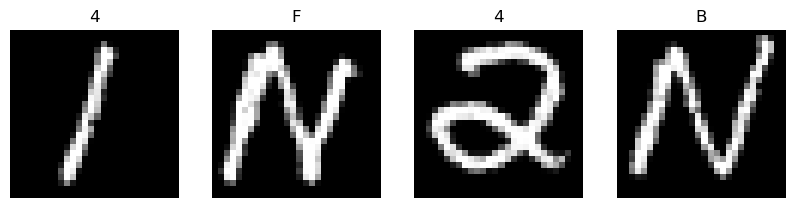

In [156]:
letter_preds = cnn_let(samples[::2])[0]
number_preds = cnn_num(samples[1::2])[0]

letter_preds_decoded = preds_to_char(letter_preds, letters)
number_preds_decoded = preds_to_char(number_preds, nums)

a = len(number_preds_decoded)
b = len(letter_preds_decoded)
string = ''
for i in range(a):
    string += number_preds_decoded[i]
    string += letter_preds_decoded[i]
if b > a:
    string += letter_preds_decoded[-1]



fig,ax = plt.subplots(1,len(samples),figsize=(10,10))
for i in range(len(samples)):
    ax[i].imshow(samples[i,0],cmap='gray')
    ax[i].set_title(string[i])
    ax[i].axis('off')

